In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

df = pd.concat((
    pd.read_csv('./data/October_missions_full.csv'),
    pd.read_csv('./data/November_1stW_missions_full.csv'),
), ignore_index=True)

df['mission'] = df['type'] + '_' + df['target'].astype(str)

df = df[['user', 'mission', 'createdAtT', 'type', 'target', 'completed', 'performance']]
df['createdAtT'] = pd.to_datetime(df['createdAtT'], unit='ms')
df['user'] = df['user'].astype('category').cat.codes
df['mission'] = df['mission'].astype('category')
df['type'] = df['type'].astype('category')

df.sort_values(by=['createdAtT', 'user'], inplace=True, ignore_index=True)
df

,user,mission,createdAtT,type,target,completed,performance
0,4845,quiz_2,2024-10-01 00:00:07.698,quiz,2,False,0.000000
1,4845,mobility_1,2024-10-01 00:00:07.698,mobility,1,True,1.000000
2,4845,activity_6,2024-10-01 00:00:07.698,activity,6,False,0.666667
3,2892,mobility_1,2024-10-01 00:00:17.857,mobility,1,False,0.000000
4,2892,episode_3,2024-10-01 00:00:17.857,episode,3,False,0.666667
...,...,...,...,...,...,...,...
110964,8089,action_2,2024-11-07 23:54:14.775,action,2,False,0.000000
110965,8089,mobility_4,2024-11-07 23:54:14.775,mobility,4,False,0.000000
110966,863,activity_9,2024-11-07 23:58:55.124,activity,9,False,0.000000
110967,863,quiz_1,2024-11-07 23:58:55.124,quiz,1,False,0.000000


/tmp/ipykernel_17244/1752879408.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['completed'] == False].groupby('mission').size().plot(kind='bar', figsize=(20, 10))


<Axes: xlabel='mission'>

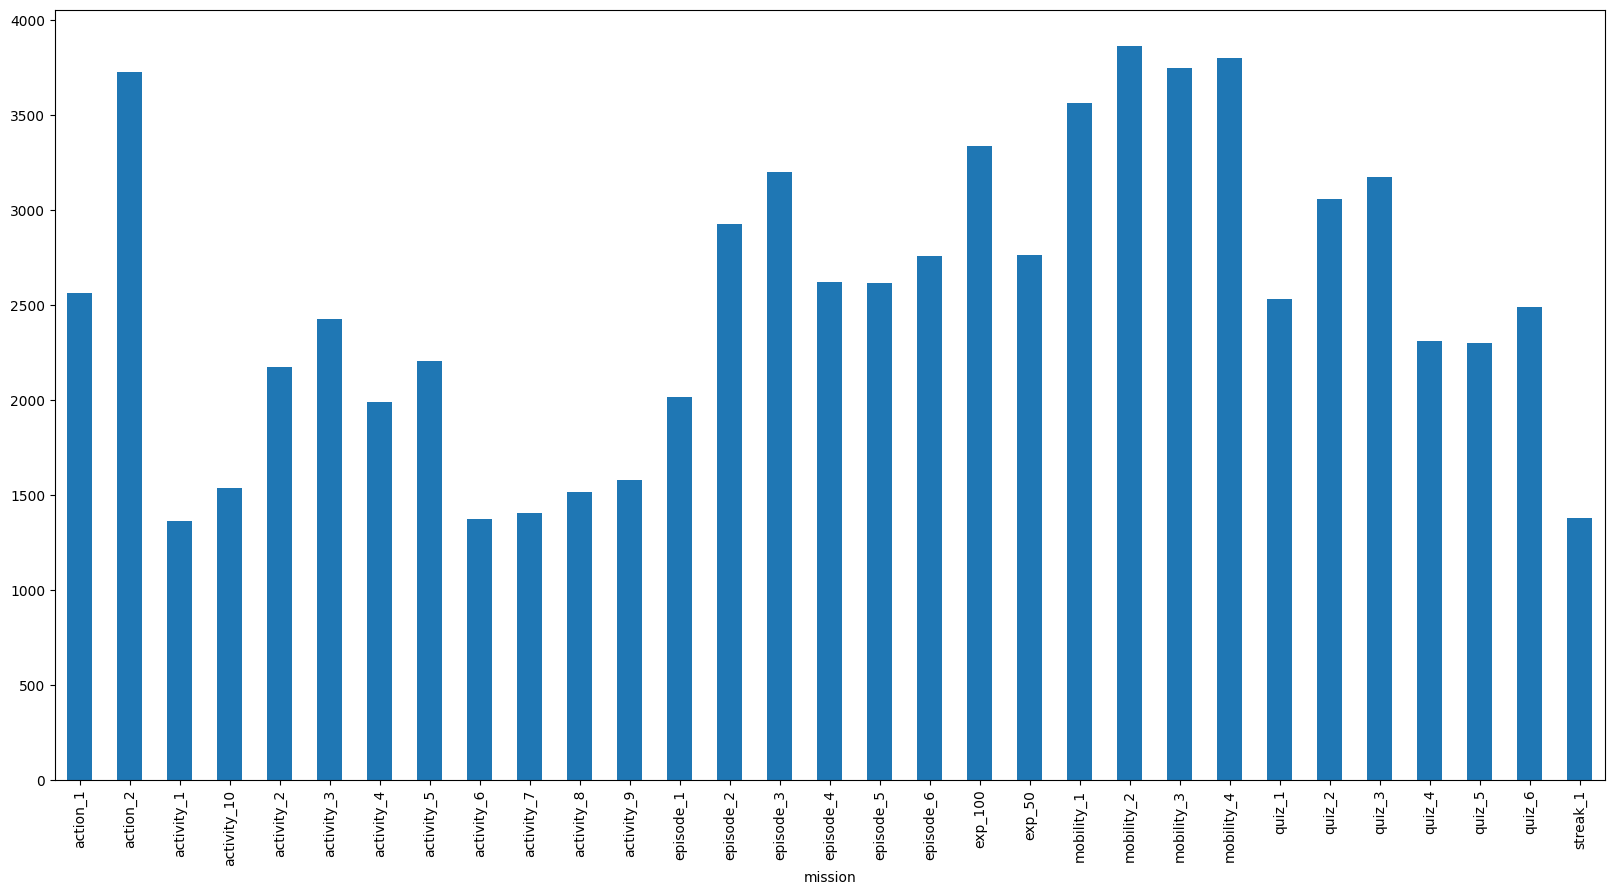

In [4]:
df[df['completed'] == False].groupby('mission').size().plot(kind='bar', figsize=(20, 10))

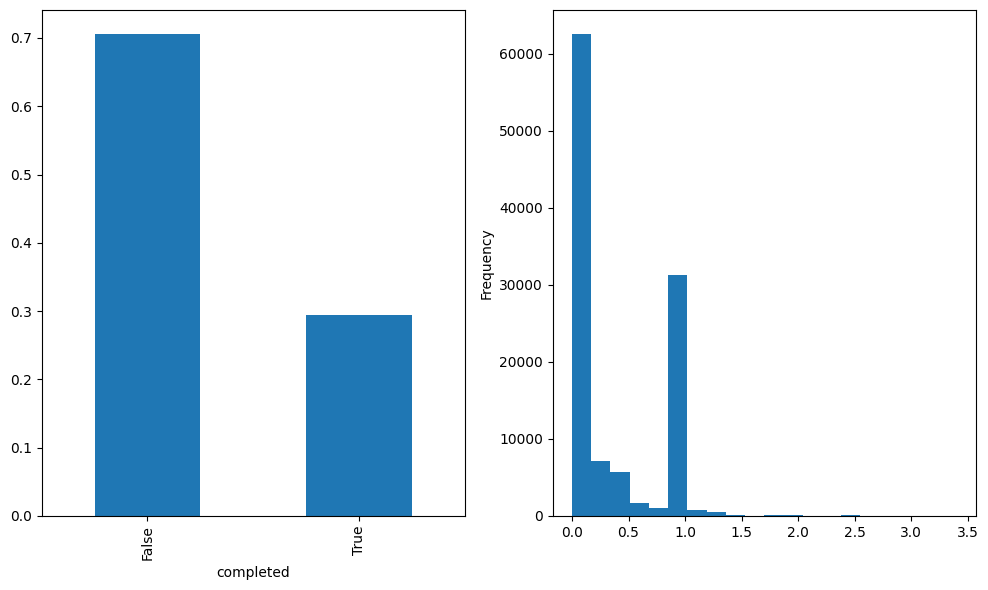

In [5]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
df['completed'].value_counts(normalize=True).plot(kind='bar')

plt.subplot(1, 2, 2)
df['performance'].plot.hist(bins=20)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

df.groupby('mission', observed=True).size().plot(kind='bar')

In [ ]:
plt.figure(figsize=(10, 6))

df.groupby('type', observed=True).size().plot(kind='bar')

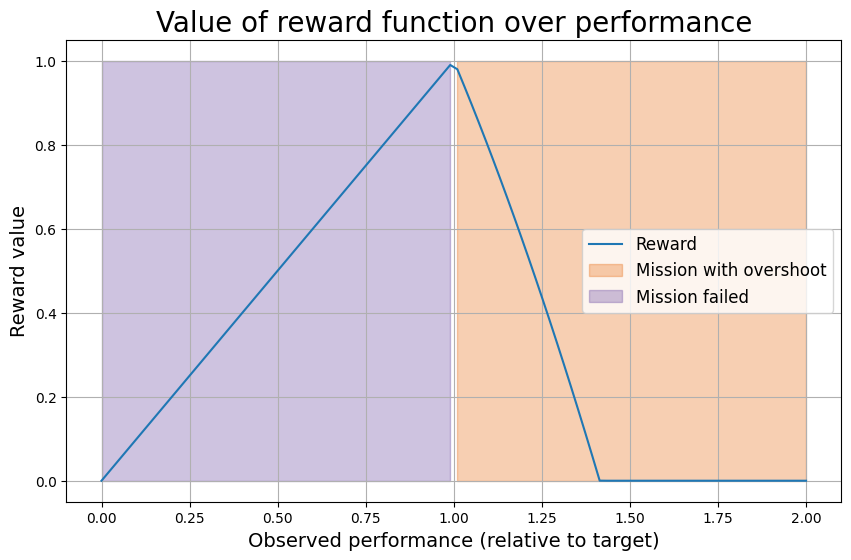

In [3]:
import numpy as np

def reward(x):
    if x <= 1:
        return x
    return np.maximum(0, 2 - np.power(x, 2))

x = np.linspace(0, 2, 100)
y = [reward(i) for i in x]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.title('Value of reward function over performance', fontsize=20)
plt.plot(x, y, label='Reward')
plt.fill_between(x, [1] * len(x), alpha=0.3, color='#E66100', where = x >= 1, label='Mission with overshoot')
plt.fill_between(x, [1] * len(x), alpha=0.3, color='#5D3A9B', where = x <= 1, label='Mission failed')
plt.legend(fontsize=12)
plt.xlabel('Observed performance (relative to target)', fontsize=14)
plt.ylabel('Reward value', fontsize=14)
plt.grid()
plt.savefig('out/reward_function.pdf', format='pdf')
plt.show()